## 💡 1. Introduction 

[TODO]

## 📚 2. Preparations

### 2.1 Importing libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix

import matplotlib.pyplot as plt

### 2.2 Importing datasets
The data storage solution provides two dataframes. We can easily import them with the use of storage magic. Storage magic is for lightweight persistance between notebooks. It stores variables, aliases and macros in IPython's database.

The data storage solution can be found here:<br>
https://github.com/i442124/SuperScope/tree/main/notebooks/

More info about storage magic can be found here:<br>
https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html

In [2]:
%store -r games ratings

In [3]:
games.head()

,gameID,title,platform,publisher,genres
0,0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nintendo,"[Fantasy, Action Adventure]"
1,1,Tony Hawk's Pro Skater 2,PlayStation,Activision,"[Sports, Skateboarding, Alternative]"
2,2,Grand Theft Auto IV,PlayStation 3,Rockstar Games,"[Open-World, Action Adventure, Modern]"
3,3,SoulCalibur,Dreamcast,Namco,"[Action, Fighting, 3D]"
4,4,Grand Theft Auto IV,Xbox 360,Rockstar Games,"[Open-World, Action Adventure, Modern]"


In [4]:
ratings.head()

,title,platform,meta_score,review_critic,criticID
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games,229
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark,147
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer,46
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Nintendophiles,306
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Electronic Gaming Monthly,86


In [5]:
print(f'The dataset contains: {len(ratings)} ratings of {len(games)} games.')

The dataset contains: 422539 ratings of 18296 games.


## 🧪3. Experimentation
Lets start off by experimenting a little with KMeans, to get a feel of how this works. KMeans operates best on data where the number of categories is known. The first thing that comes into my mind are genres of the video games. Lets start off by calulating for each user their average rating of all genres available.

In [6]:
# Split each game into multiple rows
# for each genre they have, this makes
# it easier to calculate the average score
game_ratings = pd.merge(games, ratings)
game_ratings = game_ratings.explode(column='genres')

# Calcluate average of each review_critic of each genre
game_ratings = game_ratings.groupby(['review_critic', 'genres']).mean()
game_ratings = game_ratings.reset_index().pivot('review_critic', 'genres', 'meta_score')

In [7]:
game_ratings.iloc[:10, :10]

genres,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade
review_critic,,,,,,,,,,
1UP,74.919811,66.234657,86.25,68.013678,69.178503,70.718919,68.814815,66.880000,80.0,67.941423
360 Gamer Magazine UK,67.000000,60.000000,NaN,68.512397,66.578947,76.666667,60.000000,64.000000,NaN,70.350877
3DAvenue,72.800000,76.120000,NaN,77.053846,77.081967,78.090909,71.600000,72.666667,NaN,80.708333
3DJuegos,79.644699,76.094118,82.50,76.800560,77.829060,79.241877,76.370504,76.090909,70.5,76.445946
4Players.de,76.763948,71.652720,77.15,72.563559,73.658301,76.970000,73.478261,73.666667,NaN,69.732441
9Lives,80.615385,82.615385,NaN,77.835443,78.432432,79.333333,79.000000,81.000000,72.0,77.086957
Absolute Games,72.666667,67.347826,70.75,63.207071,66.804348,67.641026,63.412698,NaN,NaN,62.379845
Absolute Playstation,90.333333,87.090909,NaN,86.807692,90.315789,86.750000,NaN,79.833333,NaN,88.200000
AceGamez,77.050505,72.181818,91.25,74.171225,73.804627,72.674157,70.069307,69.848485,60.0,74.802048


We can see a few NaN values, which indicates that this reviewer has not scored a game in this genre.

### 3.1 Action vs Adventure
Now that we have the averages of all genres for each review critic, lets compare two of the most popular genres with each other. We can use a scatter plot where the scores of the action genre on the X axis and the adventure genre on the Y axis. Spots on the bottom left indicate that the critic doesn't like action nor adventure, while the top right indicates that the critic really loves action and adventure.

In [8]:
action_adventure = game_ratings[['Action', 'Adventure']]
action_adventure = action_adventure[action_adventure['Action'].notna()]
action_adventure = action_adventure[action_adventure['Adventure'].notna()]

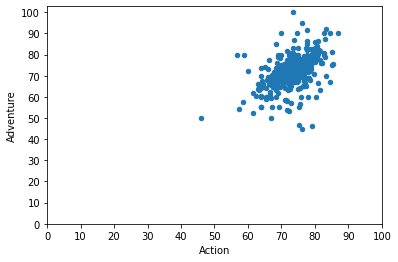

In [9]:
ax = action_adventure.plot.scatter(x='Action', y='Adventure')
ax.set_xticks(range(0, 100 + 10, 10))
ax.set_yticks(range(0, 100 + 10, 10))
plt.show()

It looks like most people enjoy action adventure as the center of all points is located in the top right. Lets check out how KMeans performs when we split these review scores into two different groups. I'd expect a segmentation somewhere around the (75,75) mark.

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

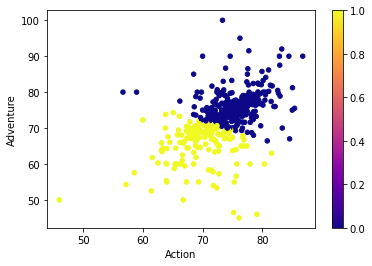

In [10]:
kmeans = KMeans(n_clusters=2)
pred = kmeans.fit_predict(action_adventure)

fig, ax = plt.subplots(1, 1)
action_adventure.plot.scatter(ax=ax, x='Action', y='Adventure', c=pred, colormap='plasma')

As we can see, the group the critic belongs to depends on if they rate adventure higher than action (or visa versa). Lets check what happens when we increase the number of clusters.

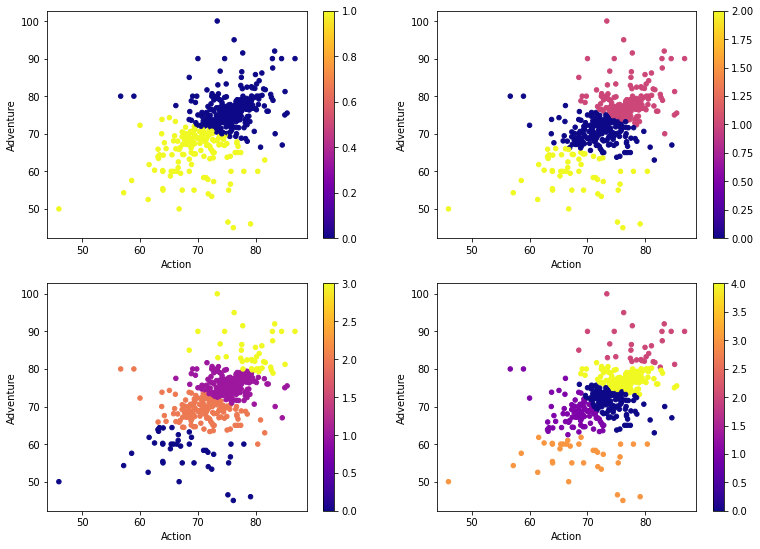

In [11]:
k_values = [2, 3, 4, 5]
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.2))

for i, k in enumerate(k_values): 
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(action_adventure)
    action_adventure.plot.scatter(ax=axs.ravel()[i], x='Action', y='Adventure', c=pred, colormap='plasma')

We start to see that the more clusters we use, the more similar the taste of each cluster blends in with the others, but what would be the most optimal value?

### 3.2 Finding Optimal K
There are several techniques we can use to determine the optimal value of K. The most popular method for finding the optimal value is known as 'The Elbow Method'. Another method I found is known as the silhouette-method which I'd like to try out as well, to see how they comapre with each other.

Usefull sources: <br>
https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set<br>
https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891<br>

In [12]:
def elbow_method(k, data):
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(data)
    return kmeans.inertia_

In [13]:
def silhouette_method(k, data):
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(data)
    return silhouette_score(data, pred)

In [14]:
def plot_optimal_k(k_values, scores):
    fig = plt.figure(figsize=(16, 6))
    
    xticks = np.arange(
        min(possible_k_values),
        max(possible_k_values)+1, 12)
    
    plt.plot(k_values, scores)
    plt.xticks(xticks, rotation=0)
    plt.grid(axis='both', which='both')

Lets start off with gathering all possible k values we can go for. KMeans is limited to the amount of entires in the dataset, which for us is the total amount of critics. We can use this scope to generate a range between 2 (the miniumum) and the amount of critics (the maximum). We use a stride of 8 to lower the performance cost.

In [15]:
possible_k_values = range(2, len(action_adventure), 8)
squared_distances = [elbow_method(k, action_adventure) for k in possible_k_values]

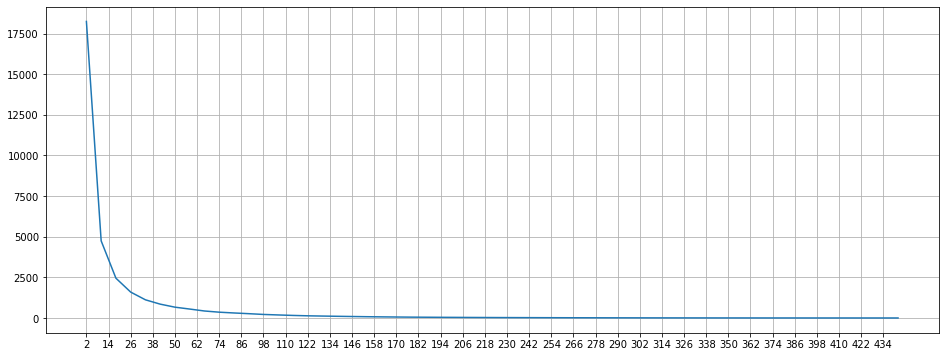

In [16]:
plot_optimal_k(possible_k_values, squared_distances)

Looks like 26 is the sweetspot according to the elbow method. This seems like a pretty high number, so lets check how the silhouette method compares.

In [17]:
possible_k_values = range(2, len(action_adventure), 8)
silhouette_scores = [silhouette_method(k, action_adventure) for k in possible_k_values]

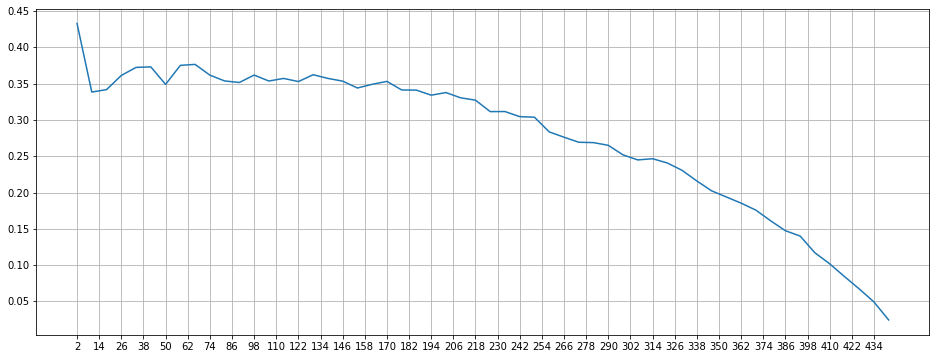

In [18]:
plot_optimal_k(possible_k_values, silhouette_scores)

In the silhouette score we see some strange behaviour where we see a deep dive after adding just one cluster. It starts climbing up aftet a few clusters but doesn't reach the same height again.

**Note to self**: Discuss with ML teacher what could be causing these issues. Most likley has something to do with data preprocessing????

## ⚙️ 4. Settings

In [19]:
K_CLUSTERS = 20

MIN_REVIEWS_WRITTEN = 20
MIN_REVIEWS_RECEIVED = 50

## 🧮 5. User-Item Matrix
Now that we are a little familiar with KMeans, lets take a look if we can cluster the critics on how they have rated the individual games. Fist we need to create a matrix on how every critic has rated every game that was ever released. Note that some games are released on multiple platforms. Because the quality/performance of the games can vary (a lot) between platforms, I decided to keep them separate.

In [20]:
def as_unique(ratings):
    collection = pd.DataFrame(ratings)
    return collection.apply(lambda x: f"{x[0]} ({x[1]})", axis=1)

In [21]:
def game_ratings_matrix(ratings):
    matrix_dimensions = dict(index='review_critic', columns='release')
    return ratings.pivot_table(**matrix_dimensions, values='meta_score')

In [22]:
ratings['release'] = as_unique(ratings)
ratings_matrix = game_ratings_matrix(ratings)

In [23]:
ratings_matrix.iloc[:10, :10]

release,#IDARB (Xbox One),#KILLALLZOMBIES (Xbox One),'Splosion Man (Xbox 360),.detuned (PlayStation 3),.hack//G.U. Last Recode (PC),.hack//G.U. Last Recode (PlayStation 4),.hack//G.U. vol. 1//Rebirth (PlayStation 2),.hack//G.U. vol. 2//Reminisce (PlayStation 2),.hack//G.U. vol. 3//Redemption (PlayStation 2),.hack//Infection Part 1 (PlayStation 2)
review_critic,,,,,,,,,,
1UP,NaN,NaN,NaN,NaN,NaN,NaN,70.0,60.0,60.0,NaN
360 Gamer Magazine UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DAvenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DJuegos,NaN,NaN,85.0,NaN,NaN,75.0,NaN,NaN,NaN,NaN
4Players.de,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9Lives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Absolute Games,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Absolute Playstation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AceGamez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Obviously critics can't play every game out there in existence, so natrually we should se a lot of NaNs. This is refered to as a sparse dataset. Unfortunately this makes it difficult to read the dataframe. However, games very a lot in popularity. If we sort the dataframe by the most reviewed games and the critics that rate the most, we should se the more 'dense' area of the dataset so we can tell what is going on.

In [24]:
def get_most_rated_games(matrix):
    game_rankings = matrix.count()
    return game_rankings.sort_values(ascending=False)


In [25]:
def get_users_who_rate_the_most(matrix):
    game_ratings = matrix.count(axis=1)
    return game_ratings.sort_values(ascending=False)

In [26]:
def sort_ratings_by_density(matrix):
    matrix = matrix.reindex(get_most_rated_games(matrix).index, axis=1)    
    matrix = matrix.reindex(get_users_who_rate_the_most(matrix).index, axis=0)
    return matrix

In [27]:
ratings_matrix_by_density = sort_ratings_by_density(ratings_matrix)
ratings_matrix_by_density.iloc[:10, :10]

release,Final Fantasy VII Remake (PlayStation 4),Ghost of Tsushima (PlayStation 4),The Last of Us Part II (PlayStation 4),God of War (PlayStation 4),Super Mario 3D World + Bowser's Fury (Switch),Paper Mario: The Origami King (Switch),Marvel's Spider-Man (PlayStation 4),Horizon Zero Dawn (PlayStation 4),Super Mario Odyssey (Switch),Uncharted 4: A Thief's End (PlayStation 4)
review_critic,,,,,,,,,,
IGN,80.0,90.0,100.0,100.0,70.0,70.0,87.0,93.0,100.0,90.0
GameSpot,100.0,70.0,80.0,90.0,90.0,80.0,90.0,90.0,100.0,100.0
Game Informer,88.0,95.0,100.0,98.0,93.0,78.0,95.0,88.0,98.0,95.0
GameZone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cheat Code Central,90.0,98.0,96.0,90.0,NaN,90.0,98.0,98.0,96.0,88.0
Worth Playing,90.0,94.0,95.0,92.0,90.0,85.0,93.0,85.0,87.0,90.0
Gaming Age,100.0,100.0,100.0,100.0,NaN,NaN,100.0,100.0,100.0,100.0
Game Revolution,100.0,80.0,70.0,100.0,90.0,NaN,80.0,90.0,100.0,90.0
GameSpy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Great! However its still a bit difficult to read. If we plot all the ratings on a heatmap we could more easily 'identify' the review score by it's color.

In [28]:
def plot_ratings_heatmap(matrix, axis_labels=True):
     
    if axis_labels:
        plt.xticks(ticks=range(len(matrix.columns)), labels=matrix.columns, rotation=90)
        plt.yticks(ticks=range(len(matrix.index)), labels=matrix.index)
    else:
        plt.xticks([])
        plt.yticks([])
    
    plt.pcolor(matrix, cmap='plasma', vmin=0, vmax=100)
    plt.gca().xaxis.tick_top()
    plt.gca().invert_yaxis()
    plt.colorbar()

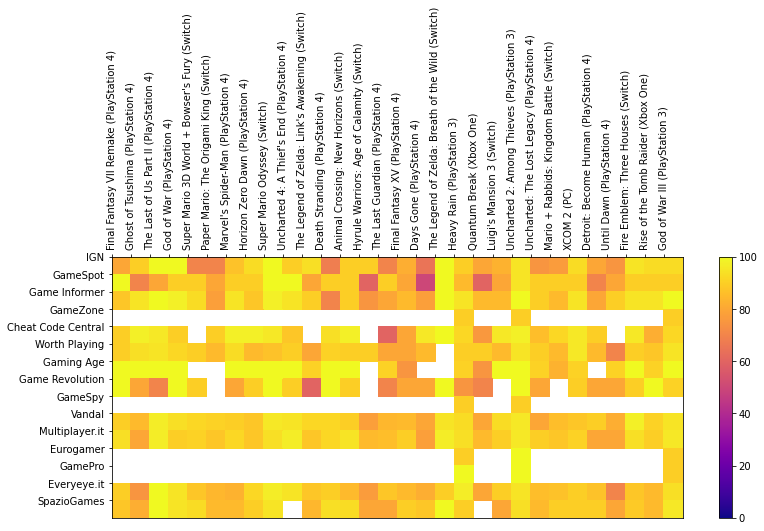

In [29]:
plt.figure(figsize=(12.8, 4.8))
plot_ratings_heatmap(ratings_matrix_by_density.iloc[:15, :30])

## 🧠 5. KMeans Clustering
https://stats.stackexchange.com/questions/450445/<br>
https://stats.stackexchange.com/questions/267322/<br>

In [30]:
def plot_heatmap_clusters(matrix, predictions):
    for i in range(K_CLUSTERS):
        
        d = matrix[predictions[matrix.reset_index().index] == i]
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        
        plt.figure(figsize=(12.8, 4.8))
        plt.pcolor(d, cmap='plasma', vmin=0, vmax=100)
        
        plt.yticks([])
        plt.xticks([])
        #plt.xticks(ticks=range(len(d.columns)), labels=d.columns, rotation=90)
        plt.title(f"Number of users: {d.shape[0]}", y=-0.1)
        
        plt.gca().xaxis.tick_top()
        plt.gca().invert_yaxis()
        plt.colorbar()

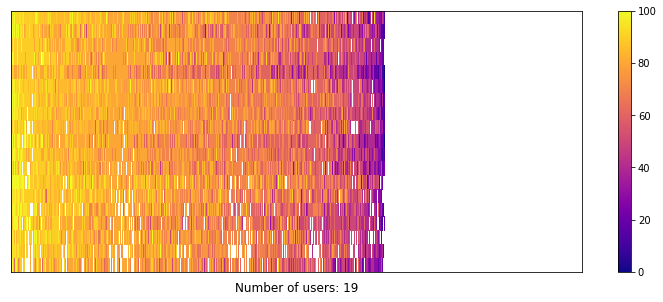

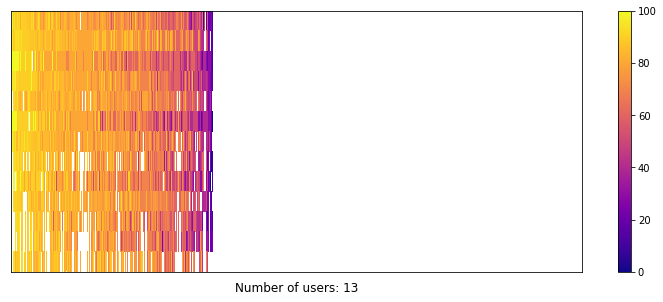

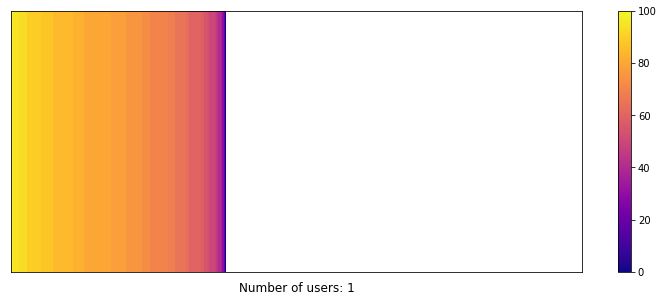

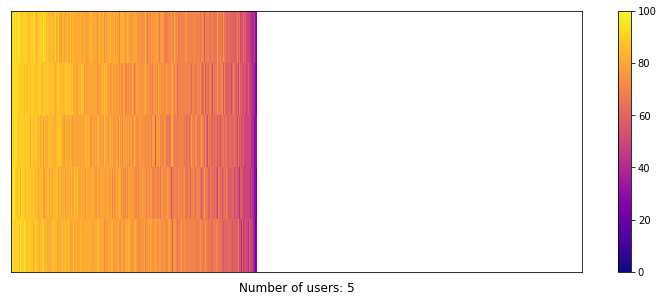

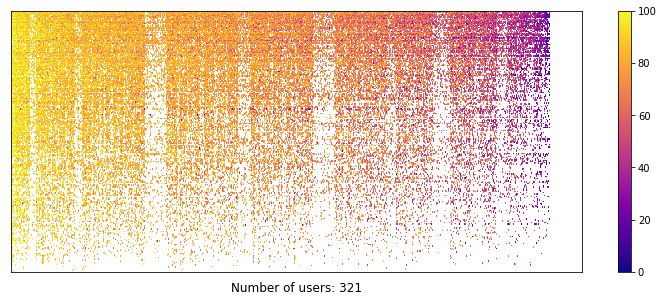

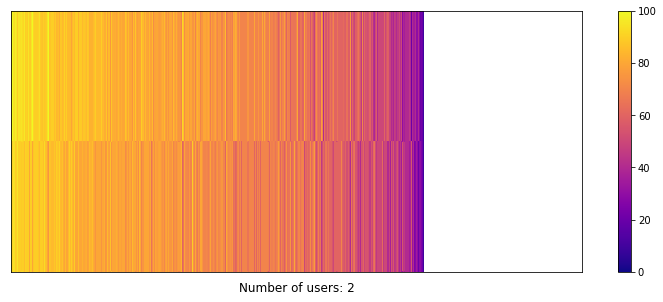

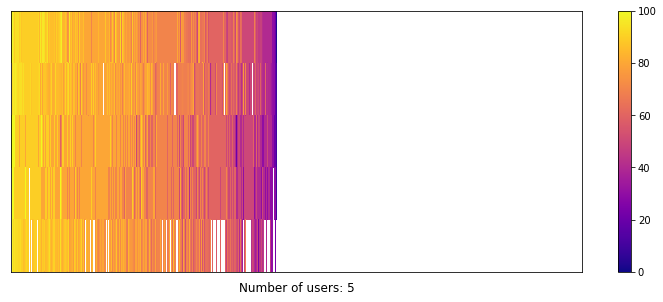

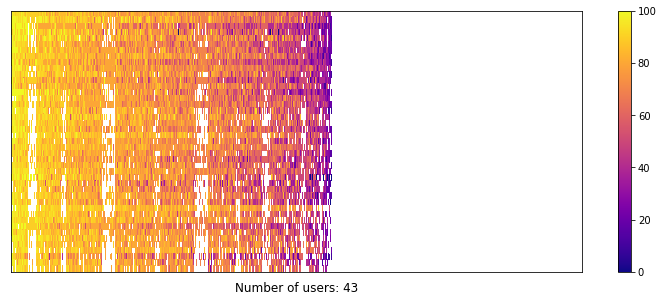

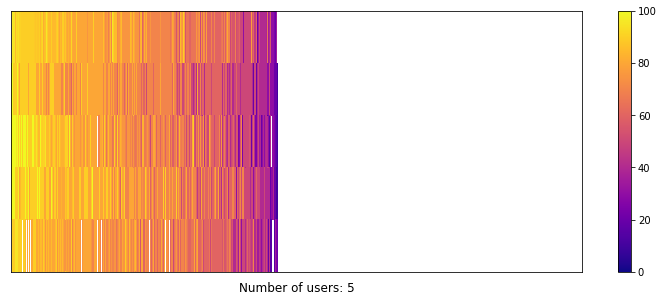

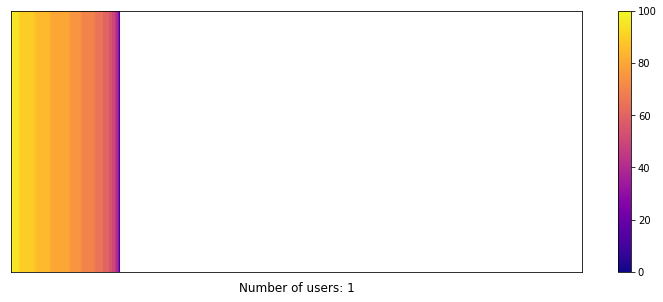

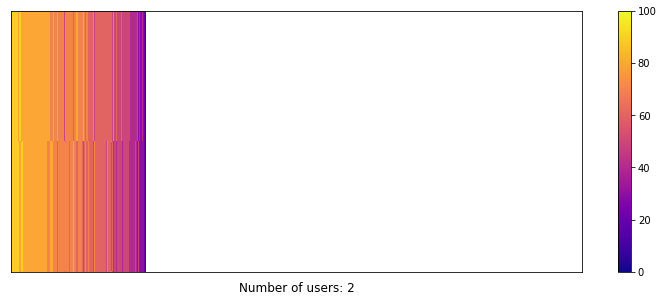

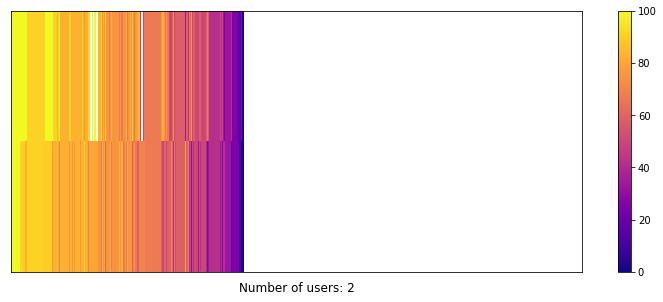

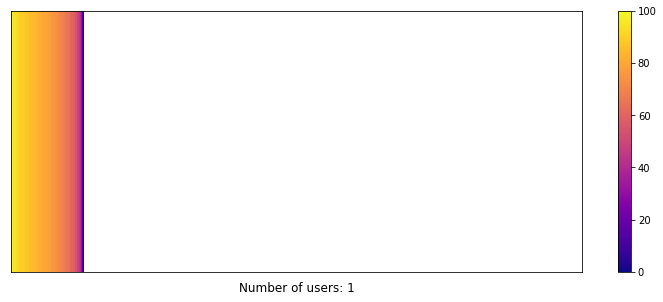

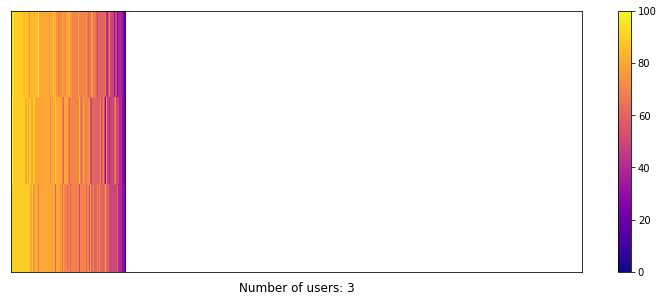

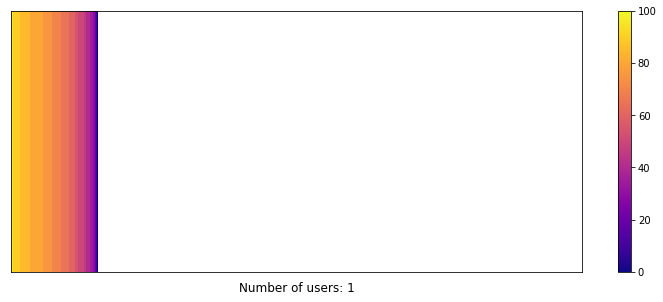

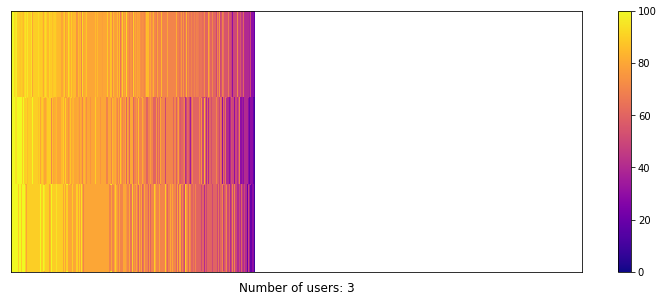

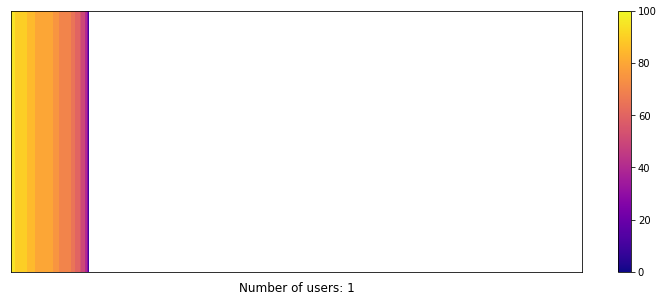

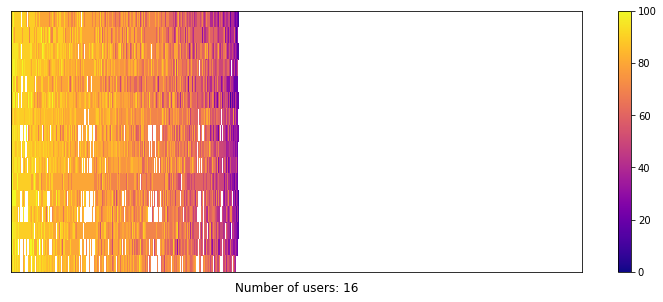

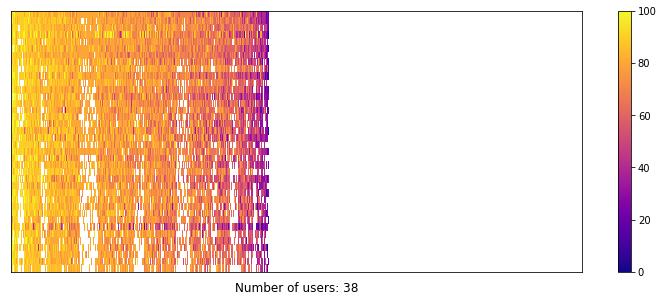

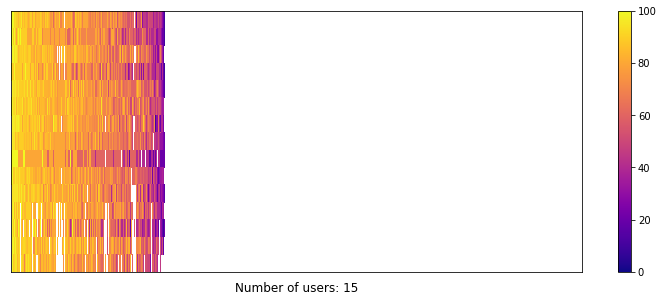

In [31]:
S = coo_matrix(ratings_matrix.fillna(0))
clusterer = KMeans(n_clusters=K_CLUSTERS, random_state=42)

predictions = clusterer.fit_predict(S.tocsr())
plot_heatmap_clusters(ratings_matrix, predictions)

## 📊 6. Recommendations

In [32]:
## TODO: ADD MY PERSONAL FAVOURITE GAMES TO REVIEW COLLECTION
custom_ratings = ratings.append({'review_critic':'Self', 'platform':'Switch', 'meta_score': 100, 'title':'Xenoblade Chronicles: Definitive Edition'}, ignore_index=True)
custom_ratings = custom_ratings.append({'review_critic':'Self', 'platform':'Switch', 'meta_score': 92, 'title':'The Legend of Zelda: Breath of the Wild'}, ignore_index=True)
custom_ratings = custom_ratings.append({'review_critic':'Self', 'platform':'Switch', 'meta_score': 95, 'title':'Super Smash Bros. Ultimate'}, ignore_index=True)
custom_ratings = custom_ratings.append({'review_critic':'Self', 'platform':'Switch', 'meta_score': 80, 'title':'Super Mario Oddesey'}, ignore_index=True)

In [33]:
# TODO: CREATE NEW MATRIX WITH PERSONAL RATIGNS ADDED
custom_ratings['release'] = as_unique(custom_ratings)
ratings_matrix = game_ratings_matrix(custom_ratings)

In [34]:
# TODO: DO PREDICTIONS ON WHAT CLUSTER I BELONG TO
S = coo_matrix(ratings_matrix.fillna(0))
clusterer = KMeans(n_clusters=K_CLUSTERS, random_state=42)
predictions = clusterer.fit_predict(S.tocsr())

In [35]:
user_id = ratings_matrix.reset_index().loc[ratings_matrix.index == 'Self'].index[0]
cluster = ratings_matrix[predictions[ratings_matrix.reset_index().index] == predictions[user_id]]
user_ratings = cluster.loc['Self']
avg_ratings = pd.concat([user_ratings, cluster.mean()], axis=1, join='inner').loc[:,0]
avg_ratings.sort_values(ascending=False)[:20]

release
Steins;Gate 0 (PlayStation Vita)                                  100.000000
The Vanishing of Ethan Carter (PlayStation 4)                     100.000000
Kentucky Route Zero (PC)                                          100.000000
Before the Echo (PC)                                              100.000000
Peggle (PlayStation 3)                                            100.000000
Axiom Verge (Switch)                                              100.000000
Flinthook (PlayStation 4)                                         100.000000
The Sexy Brutale (PlayStation 4)                                  100.000000
Beat Saber (PC)                                                   100.000000
Night in the Woods (PlayStation 4)                                100.000000
Goetia (PC)                                                       100.000000
Shantae: Risky's Revenge (DS)                                     100.000000
The Missing: JJ Macfield and the Island of Memories (Xbox One)    10

## 📝 7. Conclusion